In [1]:
# For numerical calculations
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.animation as animation
from scipy.integrate import odeint
from numpy import arange
from pylab import *
from scipy.integrate import odeint
import scipy.optimize 
from scipy.optimize import leastsq
from math import exp
from collections import OrderedDict
from sklearn.linear_model import LinearRegression
pd.options.mode.chained_assignment = None
import git

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

# Import plotting features
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("ticks")
sns.set_palette("colorblind", color_codes=True)
sns.set_context("paper")

# Magic command to plot inline
%matplotlib inline

#To graph in SVG (high def)
%config InlineBackend.figure_format="svg"

In [4]:
# Import table with data
df_cline =  pd.read_csv(f'{homedir}/ctep_wt/data/raw/cline_assay/20210322_cline.csv') 
#See data
df_cline.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group
0,0.567,standard,2.5,NaN,1.0,1.0,NaN,d
1,0.747,standard,2.5,NaN,2.0,1.0,NaN,d
2,0.857,standard,2.5,NaN,3.0,1.0,NaN,d
3,0.561,standard,1.7,NaN,1.0,1.0,NaN,d
4,0.625,standard,1.7,NaN,2.0,1.0,NaN,d
...,...,...,...,...,...,...,...,...
226,0.068,standard,0.1,NaN,2.0,1.0,NaN,b
227,0.061,standard,0.1,NaN,3.0,1.0,NaN,b
228,0.032,standard,0.0,NaN,1.0,1.0,NaN,b
229,0.033,standard,0.0,NaN,2.0,1.0,NaN,b


In [9]:
#Filter by standard group
df_cline_b = df_cline[(df_cline.stdcurve_group == 'b')]
#Filter by blank only
df_blank_b = df_cline_b[(df_cline_b.hyp_conc == 0)]
#Get the average of the absorbance for the blanks
avg_blank_b = df_blank_b['absorbance'].mean()

#Filter by second standard group
df_cline_d = df_cline[(df_cline.stdcurve_group == 'd')]
#Filter by blank only
#df_blank_d = df_cline_d[(df_cline_d.hyp_conc == 0)]
#Get the average of the absorbance for the blanks
avg_blank_d = df_blank_b['absorbance'].mean()

#Filter by third standard group
df_cline_c = df_cline[(df_cline.stdcurve_group == 'c')]
#Filter by blank only
df_blank_c = df_cline_c[(df_cline_c.hyp_conc == 0)]
#Get the average of the absorbance for the blanks
avg_blank_c = df_blank_c['absorbance'].mean()

#Subtract average of the blank absorbance from all the absorbances
#Create empty list to append the corrected absorbances
abs_corr = []
#Loop through rows in the dataframe with all the data
for i, row in df_cline.iterrows():
    #Determine corrected absorbance for the first standard group
    if row.stdcurve_group == 'd':
        absorbance = row.absorbance - avg_blank_d
    #Determine corrected absorbance for the second standard group
    elif row.stdcurve_group == 'b':
        absorbance = row.absorbance - avg_blank_b
    #Determine corrected absorbance for the third standard group
    else:
        absorbance = row.absorbance - avg_blank_c
    #Append corrected absorbance to list
    abs_corr.append (absorbance)
        
# Create a column from the list
df_cline['abs_corr'] = abs_corr
df_cline

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group,abs_corr
0,0.567,standard,2.5,NaN,1.0,1.0,NaN,d,0.535
1,0.747,standard,2.5,NaN,2.0,1.0,NaN,d,0.715
2,0.857,standard,2.5,NaN,3.0,1.0,NaN,d,0.825
3,0.561,standard,1.7,NaN,1.0,1.0,NaN,d,0.529
4,0.625,standard,1.7,NaN,2.0,1.0,NaN,d,0.593
...,...,...,...,...,...,...,...,...,...
226,0.068,standard,0.1,NaN,2.0,1.0,NaN,b,0.036
227,0.061,standard,0.1,NaN,3.0,1.0,NaN,b,0.029
228,0.032,standard,0.0,NaN,1.0,1.0,NaN,b,0.000
229,0.033,standard,0.0,NaN,2.0,1.0,NaN,b,0.001


In [10]:
#Make standard curve

#Filter by standard group
df_cline_d = df_cline[(df_cline.stdcurve_group == 'd')]
df_cline_b = df_cline[(df_cline.stdcurve_group == 'b')]
df_cline_c = df_cline[(df_cline.stdcurve_group == 'c')]

#Filter by standard only for the first standard group
df_standard_d = df_cline_d[(df_cline_d.type == 'standard')]
#Filter by standard only for the second standard group
df_standard_b = df_cline_b[(df_cline_b.type == 'standard')]
#Filter by standard only for the third standard group
df_standard_c = df_cline_c[(df_cline_c.type == 'standard')]

# Calculate linear regression for the first standard group
z_b = np.polyfit(df_standard_b.abs_corr, df_standard_b.hyp_conc, 1)
p_b = np.poly1d(z_b)
# Calculate linear regression for the second standard group
z_d = np.polyfit(df_standard_d.abs_corr, df_standard_d.hyp_conc, 1)
p_d = np.poly1d(z_d)
# Calculate linear regression for the third standard group
z_c = np.polyfit(df_standard_c.abs_corr, df_standard_c.hyp_conc, 1)
p_c = np.poly1d(z_c)

#Insert into a new column in the standard dataframe for the first standard group
df_standard_b.insert(4,'reg',p_b(df_standard_b['abs_corr']))
df_standard_b.head()

,absorbance,type,hyp_conc,treatment,reg,well,replicate,time_h,stdcurve_group,abs_corr
213,0.806,standard,2.5,NaN,2.326618,1.0,1.0,NaN,b,0.774
214,0.841,standard,2.5,NaN,2.435103,2.0,1.0,NaN,b,0.809
215,0.831,standard,2.5,NaN,2.404108,3.0,1.0,NaN,b,0.799
216,0.394,standard,1.0,NaN,1.049594,1.0,1.0,NaN,b,0.362
217,0.420,standard,1.0,NaN,1.130183,2.0,1.0,NaN,b,0.388


In [11]:
#Insert into a new column in the standard dataframe for the second standard group
df_standard_d.insert(4,'reg',p_d(df_standard_d['abs_corr']))
df_standard_d.head()

,absorbance,type,hyp_conc,treatment,reg,well,replicate,time_h,stdcurve_group,abs_corr
0,0.567,standard,2.5,NaN,1.750685,1.0,1.0,NaN,d,0.535
1,0.747,standard,2.5,NaN,2.338411,2.0,1.0,NaN,d,0.715
2,0.857,standard,2.5,NaN,2.697576,3.0,1.0,NaN,d,0.825
3,0.561,standard,1.7,NaN,1.731094,1.0,1.0,NaN,d,0.529
4,0.625,standard,1.7,NaN,1.940063,2.0,1.0,NaN,d,0.593


In [12]:
#Insert into a new column in the standard dataframe for the third standard group
df_standard_c.insert(4,'reg',p_c(df_standard_c['abs_corr']))
df_standard_c.head()

,absorbance,type,hyp_conc,treatment,reg,well,replicate,time_h,stdcurve_group,abs_corr
132,1.041,standard,2.08,NaN,2.076804,NaN,NaN,NaN,c,1.007
133,1.004,standard,2.08,NaN,2.002847,NaN,NaN,NaN,c,0.970
134,0.867,standard,2.08,NaN,1.729008,NaN,NaN,NaN,c,0.833
135,0.713,standard,1.38,NaN,1.421188,NaN,NaN,NaN,c,0.679
136,0.678,standard,1.38,NaN,1.351229,NaN,NaN,NaN,c,0.644


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'Concentration ($mM$)')

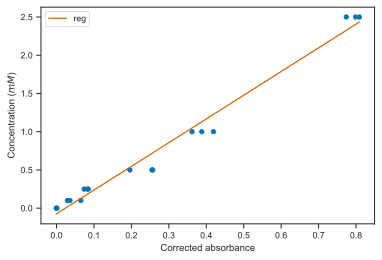

In [18]:
#Plot the regression line for the standard from the first standard group
ax = df_standard_b.plot.scatter(x = 'abs_corr',y='hyp_conc')
df_standard_b.plot(x = 'abs_corr',y='reg',c='r',ax=ax)
ax.set_xlabel('Corrected absorbance')
ax.set_ylabel('Concentration ($mM$)')

In [19]:
# Calculate the concentration of each sample

# Create empty list to append concentrations
conc = []
#Loop through full dataframe
for i, row in df_cline.iterrows():
    #Apply the linear regression for the first standard group samples based on the standard curve for that plate
    if row.stdcurve_group == 'b':
        real_conc = row.abs_corr *z_b[0] + z_b[1]
     #Apply the linear regression for the second standard group samples based on the standard curve for that plate
    elif row.stdcurve_group == 'd':
        real_conc = row.abs_corr *z_d[0] + z_d[1]
    #Apply the linear regression for the third standard group samples based on the standard curve for that plate
    else:
        real_conc = row.abs_corr *z_c[0] + z_c[1]
    #Append calculated concentrations to list
    conc.append (real_conc)
        
# Create a column from the list
df_cline['concentration'] = conc
df_cline.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group,abs_corr,concentration
0,0.567,standard,2.5,NaN,1.0,1.0,NaN,d,0.535,1.750685
1,0.747,standard,2.5,NaN,2.0,1.0,NaN,d,0.715,2.338411
2,0.857,standard,2.5,NaN,3.0,1.0,NaN,d,0.825,2.697576
3,0.561,standard,1.7,NaN,1.0,1.0,NaN,d,0.529,1.731094
4,0.625,standard,1.7,NaN,2.0,1.0,NaN,d,0.593,1.940063


In [20]:
# Filter by sample only
df_samples = df_cline[(df_cline.type == 'sample')]
df_samples.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group,abs_corr,concentration
21,0.451,sample,NaN,d,1.0,1.0,18.25,d,0.419,1.371928
22,0.478,sample,NaN,d,2.0,1.0,18.25,d,0.446,1.460087
23,0.448,sample,NaN,d,3.0,1.0,18.25,d,0.416,1.362133
24,0.471,sample,NaN,d,1.0,2.0,18.25,d,0.439,1.437231
25,0.489,sample,NaN,d,2.0,2.0,18.25,d,0.457,1.496004


In [22]:
#Get average concentrations of the three wells for each replicate
df_samples['avg_conc'] = df_samples.groupby(['replicate','time_h'])['concentration'].transform(mean)
df_samples.head()

,absorbance,type,hyp_conc,treatment,well,replicate,time_h,stdcurve_group,abs_corr,concentration,avg_conc
21,0.451,sample,NaN,d,1.0,1.0,18.25,d,0.419,1.371928,1.398049
22,0.478,sample,NaN,d,2.0,1.0,18.25,d,0.446,1.460087,1.398049
23,0.448,sample,NaN,d,3.0,1.0,18.25,d,0.416,1.362133,1.398049
24,0.471,sample,NaN,d,1.0,2.0,18.25,d,0.439,1.437231,1.449203
25,0.489,sample,NaN,d,2.0,2.0,18.25,d,0.457,1.496004,1.449203


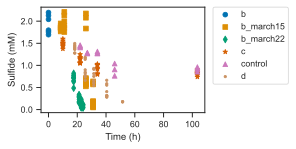

In [23]:
#Make a plot of concentration vs. time
# Group by treatment
df_group = df_samples.groupby(['treatment'])
# Define colors
colors = sns.color_palette('colorblind', n_colors=len(df_group))
# Define markers
markers = ['o', 's', 'd','*','^','.','.']

# Define fig and axes
#fig, ax = plt.subplots(1,3, figsize=(9,6))

fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

# Loop through replicates
for i, (group, data) in enumerate(df_group):
    ax.scatter(data.time_h, data.concentration, color=colors[i], marker=markers[i],
              label = group)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Sulfide (mM)')
#Show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [100]:
print(df_samples.columns)

Index(['cell', 'absorbance', 'type', 'hyp_conc', 'treatment', 'well',
       'replicate', 'time_h', 'date', 'abs_corr', 'concentration', 'avg_conc'],
      dtype='object')


No handles with labels found to put in legend.


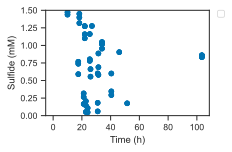

In [24]:
#Make a plot of concentration vs. time

fig = plt.figure(figsize=(2.95, 1.95), dpi=192)
ax = fig.add_subplot(111)

ax.scatter(df_samples['time_h'], df_samples['avg_conc'])#, color=colors[i], marker=markers[i],
              #label = group)
ax.set_xlabel('Time (h)')
ax.set_ylabel('Sulfide (mM)')
ax.set_ylim(0,1.5,0.3)
#Show legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)